# CryptoProphet
## Notebook's Goal
> To test the hypothesis that tweets of influencers have an effect on the price of crypto, we take the tweets and try to solve a classicfication problem using XGBoost. For this approach we have 2 parameters we tried out, namely the number of classes we want to predict and the time of the future price prediction. In this notebook 5 classes were used namely: 'STONG_DECREASE', 'DECREASE', 'NEUTRAL', 'INCREASE', 'STRONG_INCREASE. And the time of the price prediction is 2 hours after the tweet was published. other combinations of classes and prediction times where tried in Notebooks 8b to 8e.




In [1]:
# imports custom packages
from src.paths import LOCAL_RAW_DATA_PATH, LOCAL_PROCESSED_DATA_PATH, LOCAL_MODELS_PATH

# imports official packages
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm._tqdm_notebook import tqdm_notebook
from collections import OrderedDict
from xgboost import plot_importance
import matplotlib.pyplot as plt 
from scipy.stats import skew
import missingno as msno
import pandas as pd
import xgboost
import pickle

tqdm_notebook.pandas()
seed = 42

# imports dataset with tweets in form of a panda dataframe
df_path = LOCAL_PROCESSED_DATA_PATH / 'pretrain_dataset_20211013.pkl'
df = pd.read_pickle(df_path)
tgt_vars = [c for c in df.columns if '_change_' in str(c)]

# some informations are unnnecessary so we drop unused columns of the dataframe
drop_cols = ['created_at', 'created_at_trunc_h', 'id_str',
             'full_text', 'user_screen_name',
             'ma_120_periods', 'ma_720_periods'] + tgt_vars
X_cols = [c for c in df.columns if c not in drop_cols]

C:\Users\hohih\anaconda3\envs\makeathon\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  


In [2]:
df

,created_at,created_at_trunc_h,id_str,full_text,retweet_count,favorite_count,user_screen_name,user_feat,BTC,DOGE,...,758,759,760,761,762,763,764,765,766,767
67894,2019-06-24 00:48:17,2019-06-24 00:00:00,1142957583340380160,@roysebag @mikejcasey https://t.co/HAdE9hivHb,1.0,5.0,BarrySilbert,3,0,0,...,0.211892,0.090323,-0.033169,-0.074099,0.049208,0.008833,0.092621,-0.013973,-0.091649,-0.009876
109535,2019-06-24 01:45:59,2019-06-24 01:00:00,1142972105182601216,@SoroushG_ @hasufl Perhaps expanding to non-ec...,0.0,4.0,FEhrsam,14,0,0,...,0.159535,0.046459,-0.129009,-0.051730,0.037167,0.012580,0.112651,-0.005474,0.065391,0.004129
89071,2019-06-24 03:39:16,2019-06-24 03:00:00,1143000611329388544,@NPO_SPS_2013 @Emurgo_Japan 投稿ありがとうございました！是非、 ...,1.0,30.0,Cardano,5,0,0,...,-0.211426,-0.008754,0.002088,-0.107030,0.079004,0.251885,0.013369,-0.043283,0.211008,0.042472
89070,2019-06-24 04:04:05,2019-06-24 04:00:00,1143006856761266176,"On June 22, #CardanoFoundation attended the fi...",50.0,235.0,Cardano,5,0,0,...,-0.063294,0.127559,0.099624,-0.001857,-0.068960,0.112617,-0.000934,0.009449,0.031449,0.055679
89069,2019-06-24 04:23:13,2019-06-24 04:00:00,1143011672560427008,ご注意ください：ダイダロスのサポートをすると言ってデータを抜き取り#ADA を盗まれるという...,42.0,123.0,Cardano,5,0,0,...,-0.196956,-0.077403,0.033810,-0.181430,0.158272,0.118863,-0.029405,-0.137520,0.256907,-0.011696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123921,2021-06-12 18:55:54,2021-06-12 18:00:00,1403788163697364992,RT @TheMoonCarl: #Bitcoin is no longer a risky...,151.0,0.0,TheMoonCarl,24,0,0,...,-0.147888,0.025996,-0.084869,0.037063,-0.001910,0.226132,0.031749,0.018368,0.036949,-0.009420
43602,2021-06-12 20:03:49,2021-06-12 20:00:00,1403805256434212864,Is Bitcoin in a BULL market or BEAR market?\n\...,29.0,527.0,TheMoonCarl,24,1,0,...,0.096598,0.063076,0.020786,0.039058,0.109760,-0.048143,-0.012668,0.008022,-0.020895,0.069427
43600,2021-06-12 20:26:39,2021-06-12 20:00:00,1403811003532333056,"Cardano, Ethereum, Polkadot, &amp; Bitcoin Hol...",38.0,346.0,AltcoinDailyio,2,1,0,...,0.070578,0.007546,-0.116885,-0.054518,-0.191919,0.011983,-0.057460,0.072940,0.030190,0.071841
43599,2021-06-12 20:47:42,2021-06-12 20:00:00,1403816301085138944,RT @jack: 🇳🇬🤝#bitcoin,16790.0,0.0,AltcoinDailyio,2,0,0,...,-0.008247,0.222700,0.280219,0.107308,-0.070336,-0.003214,0.177103,-0.083579,0.022853,0.046477


In [21]:
# We extract quantiles in order to form 5 classes based on, if a value lies in a certain range or not
df['close_change_2periods_perc_5Q'] = pd.qcut(df['close_change_2periods_perc'], q=5)
quant2text = {}
scale = ['STONG_DECREASE', 'DECREASE', 'NEUTRAL', 'INCREASE', 'STRONG_INCREASE']
for i, v in enumerate(df['close_change_2periods_perc_5Q'].unique().sort_values()):
    quant2text[v] = scale[i] + f'_Q{i+1}' 
    
quant2text

{Interval(-0.136, -0.00702, closed='right'): 'STONG_DECREASE_Q1',
 Interval(-0.00702, -0.00158, closed='right'): 'DECREASE_Q2',
 Interval(-0.00158, 0.00193, closed='right'): 'NEUTRAL_Q3',
 Interval(0.00193, 0.00773, closed='right'): 'INCREASE_Q4',
 Interval(0.00773, 0.146, closed='right'): 'STRONG_INCREASE_Q5'}

In [25]:
# map quantiles to human readable form, basicallly a text 'STONG_DECREASE', 'DECREASE', ...
df['close_change_2periods_perc_5Q_HR'] = df['close_change_2periods_perc_5Q'].map(quant2text)

# sets X and y for training
X = df[X_cols]
y = df['close_change_2periods_perc_5Q_HR']

In [27]:
# sanity check on null values
X.isna().sum().sum(), y.isna().sum()

(0, 0)

In [28]:
# splits dataset into train and test datasets. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

In [29]:
# sanity check on resulting shapes
print(X_train.shape,  X_test.shape)
print(y_train.shape,  y_test.shape)
df.shape[0] == X_train.shape[0] + X_test.shape[0] 

(73656, 779) (18415, 779)
(73656,) (18415,)


True

In [3]:
# initialize and fits model using XGBoost
xgboost.set_config(**{'use_rmm': False, 'verbosity': 1})

model = xgboost.XGBRFClassifier(**{
    'colsample_bytree': 0.8,
    'gamma': 0,
    'learning_rate': 0.01,
    'max_depth': 5,
    'min_child_weight': 1.5,
    'n_estimators': 1200,
    'reg_alpha': 0.75,
    'reg_lambda': 0.45,
    'seed': seed,
    'subsample': 0.9
}) 

model.fit(X_train,y_train)

NameError: name 'X_train' is not defined

In [32]:
# export the model to pickle file
with open(LOCAL_MODELS_PATH / 'xgboost_20211014_XGBRFClassifier.pkl', mode='wb') as fp:
    pickle.dump(model, fp)

In [41]:
# shows overall score of the model
accuracy_score(y, model.predict(X))

0.3819769525692129

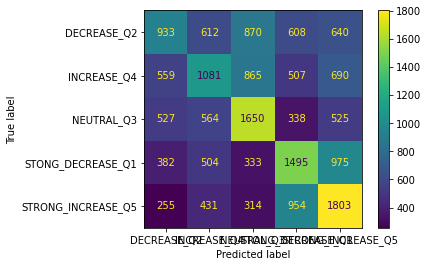

In [37]:
# plots results in a confusion matrix to try to evalute the model
plot_confusion_matrix(model, X_test, y_test)  

In [46]:
# exports data
with open(LOCAL_MODELS_PATH / 'user_label_encoder.pkl', 'rb') as fp:
    user_le = pickle.load(fp)

In [63]:
# prints score ordered by influencers accuracy
user2score = []
for u in X_train.user_feat.unique():
    mask = X.user_feat == u
    user_screen_name = user_le.inverse_transform([u])[0]
    stats ={
        'user_label': u,
        'user_screen_name': user_screen_name,
        'accuracy': model.score(X[mask], y[mask]),
        'tweet_count': mask.sum()}
    user2score.append(stats)
user2score = pd.DataFrame(user2score).sort_values('accuracy', ascending=False)

user2score

,user_label,user_screen_name,accuracy,tweet_count
14,41,officialmcafee,0.496445,3235
31,19,PeterMcCormack,0.487963,3240
6,17,LayahHeilpern,0.439926,3246
37,14,FEhrsam,0.436202,337
17,33,danheld,0.419315,3241
30,16,KennethBosak,0.410435,3450
2,34,davidgokhshtein,0.403478,3450
7,15,IvanOnTech,0.399120,3410
15,28,VitalikButerin,0.398308,3191
23,12,ErikVoorhees,0.397157,3447


# Conclusion
> Model overall contains too much noise, however some influencer show promissing results. Mots of the results are over 30% so the model performs better than a random classifier.
> (eg. PeterMcCormack with accuracy of 0.487963).
>Other combinations of classes/prediction time perform better.
>